In [1]:
!pip install timm lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.8 MB/s eta 0:00:00


In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import re
import timm
import lpips
from tqdm import tqdm
import numpy as np

def get_identifier(filename):
    match = re.search(r'p\d+', filename)  # Match pattern 'p' followed by digits
    return match.group(0) if match else None

# Custom Dataset class for loading images on-the-fly
class PairedImageDataset(Dataset):
    def __init__(self, inputs, targets, transform=None):
        self.inputs = inputs
        self.targets = targets
        self.sar_images = [f for f in os.listdir(inputs) if f.endswith(('.jpg', '.png'))]
        self.optical_images = [f for f in os.listdir(targets) if f.endswith(('.jpg', '.png'))]
        self.transform = transform

        # Ensure that the lists are ordered
        self.sar_images.sort()
        self.optical_images.sort()

        # Check if the images match in both folders
        self.sar_images = {get_identifier(f): f for f in self.sar_images}
        self.optical_images = {get_identifier(f): f for f in self.optical_images}

        common_ids = set(self.sar_images.keys()) & set(self.optical_images.keys())
        self.sar_images = [self.sar_images[i] for i in common_ids]
        self.optical_images = [self.optical_images[i] for i in common_ids]

    def __len__(self):
        return len(self.sar_images)

    def __getitem__(self, idx):
        sar_image_path = os.path.join(self.inputs, self.sar_images[idx])
        optical_image_path = os.path.join(self.targets, self.optical_images[idx])

        # Open images
        sar_image = Image.open(sar_image_path).convert('L')  # Grayscale
        optical_image = Image.open(optical_image_path).convert('RGB')  # RGB

        # Resize images
        sar_image = sar_image.resize((224, 224))
        optical_image = optical_image.resize((224, 224))

        # Convert grayscale to RGB by duplicating channels
        sar_image = sar_image.convert('RGB')  # This will now have 3 channels

        if self.transform:
            sar_image = self.transform(sar_image)
            optical_image = self.transform(optical_image)

        # Convert to numpy arrays and then to torch tensors
        sar_image = np.array(sar_image).astype(np.float32)  # Now it has 3 channels
        optical_image = np.array(optical_image).astype(np.float32)

        # Convert to torch tensors
        sar_image = torch.tensor(sar_image).permute(2, 0, 1)  # [3, 224, 224]
        optical_image = torch.tensor(optical_image).permute(2, 0, 1)  # [3, 224, 224]

        return sar_image, optical_image

# Define your models and training setup
class SwinEncoder(nn.Module):
    def __init__(self):
        super(SwinEncoder, self).__init__()
        self.swin_model = timm.create_model('swin_base_patch4_window7_224', pretrained=True, features_only=True)

    def forward(self, x):
        # Extract multiple feature maps
        features = self.swin_model(x)  # This will give you a list of feature maps at different stages
        print("Swin Encoder Feature Shapes:", [f.shape for f in features])  # Check shapes of all features

        # Permute the features to match the PyTorch convention [batch_size, channels, height, width]
        x1 = features[1].permute(0, 3, 1, 2)  # High-resolution feature map
        x2 = features[2].permute(0, 3, 1, 2)  # Medium-resolution feature map
        x3 = features[3].permute(0, 3, 1, 2)  # Low-resolution feature map

        return x1, x2, x3


ModuleNotFoundError: No module named 'lpips'

In [3]:
class HRNetDecoder(nn.Module):
    def __init__(self, num_classes=3):
        super(HRNetDecoder, self).__init__()

        # Define multiple resolution branches (high, medium, low resolution)
        self.branch1 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1)
        )

        self.branch2 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1)
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1)
        )

        # Upsample lower resolutions to match higher resolution
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.upsample3 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)

        # Final fusion
        self.final_fusion = nn.Sequential(
            nn.Conv2d(256 + 512 + 1024, 256, kernel_size=1),  # Fuse the features
            nn.ReLU(inplace=True),
            nn.Conv2d(256, num_classes, kernel_size=1)  # Final prediction
        )

        # Upsample to match target size
        self.upsample_final = nn.Upsample(size=(224, 224), mode='bilinear', align_corners=True)

    def forward(self, x1, x2, x3):
        # Process each resolution
        out1 = self.branch1(x1)  # High-resolution branch
        out2 = self.branch2(x2)  # Medium-resolution branch
        out3 = self.branch3(x3)  # Low-resolution branch

        # Upsample lower resolutions
        out2 = self.upsample2(out2)
        out3 = self.upsample3(out3)

        # Fuse all resolutions
        fused = torch.cat([out1, out2, out3], dim=1)

        # Final prediction
        output = self.final_fusion(fused)

        # Upsample to match target size (224x224)
        output = self.upsample_final(output)

        return output

# Example usage: Adjust HRNetDecoder initialization in the model
class SwinHRNetModel(nn.Module):
    def __init__(self):
        super(SwinHRNetModel, self).__init__()
        self.encoder = SwinEncoder()  # Your Swin Transformer Encoder
        self.decoder = HRNetDecoder(num_classes=3)  # HRNet Decoder

    def forward(self, x):
        # Assuming Swin Encoder outputs multiple resolutions
        x1, x2, x3 = self.encoder(x)  # Extract features from different resolution levels

        # Decode using HRNet
        output = self.decoder(x1, x2, x3)
        return output

def visualize_single_output(model, dataloader, index=0):
    model.eval()
    with torch.no_grad():
        # Get a specific batch of inputs and targets
        inputs, targets = next(iter(dataloader))
        inputs = inputs.to(device)

        # Generate outputs
        outputs = model(inputs)

        # Select the output image at the specified index
        output_image = outputs[index].cpu().numpy().transpose(1, 2, 0)  # [height, width, channels]
        output_image = (output_image).astype(np.uint8)  # Scale to 0-255

        # Display the output image
        plt.imshow(output_image)
        plt.axis('off')
        plt.title(f'Generated Image at Index {index}')
        plt.show()

In [4]:
!unrar x "/content/drive/MyDrive/agri.rar" "/content/drive/MyDrive"

Streaming output truncated to the last 5000 lines.
Extracting  /content/drive/MyDrive/agri/Optical/ROIs1970_fall_s2_19_p788.png      53%  OK 
Extracting  /content/drive/MyDrive/agri/Optical/ROIs1970_fall_s2_19_p789.png      53%  OK 
Extracting  /content/drive/MyDrive/agri/Optical/ROIs1970_fall_s2_19_p79.png      53%  OK 
Extracting  /content/drive/MyDrive/agri/Optical/ROIs1970_fall_s2_19_p790.png      53%  OK 
Extracting  /content/drive/MyDrive/agri/Optical/ROIs1970_fall_s2_19_p791.png      53%  OK 
Extracting  /content/drive/MyDrive/agri/Optical/ROIs1970_fall_s2_19_p792.png      53%  OK 
Extracting  /content/drive/MyDrive/agri/Optical/ROIs1970_fall_s2_19_p793.png      53%  OK 
Extracting  /content/drive/MyDrive/agri/Optical/ROIs1970_fall_s2_19_p794.png      53%  OK 
Extracting  /content/drive/MyDrive/agri/Optical/ROIs1970_fall_s2_19_p795.png      53%  OK 
Extracting  /content/drive/MyDrive/agri/Optical/RO

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 101MB/s] 
/usr/local/lib/python3.11/dist-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly.

Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:03<05:24,  3.68s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:04<03:02,  2.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:45<28:39, 20.00s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:46<17:42, 12.50s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:47<11:41,  8.35s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:48<08:05,  5.85s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:49<05:49,  4.27s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:50<04:21,  3.23s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:52<03:23,  2.54s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:53<02:43,  2.07s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:54<02:17,  1.76s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:55<01:57,  1.53s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:56<01:44,  1.37s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:57<01:34,  1.26s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:58<01:27,  1.19s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:59<01:23,  1.15s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [01:00<01:19,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [01:01<01:16,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [01:02<01:13,  1.06s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [01:03<01:11,  1.04s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [01:04<01:10,  1.03s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [01:05<01:08,  1.03s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [01:06<01:07,  1.03s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [01:07<01:06,  1.03s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [01:08<01:06,  1.03s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [01:09<01:04,  1.03s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [01:10<01:03,  1.02s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [01:11<01:02,  1.02s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [01:12<01:01,  1.02s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [01:13<01:00,  1.02s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [01:14<00:59,  1.02s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [01:15<00:58,  1.02s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [01:16<00:57,  1.02s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [01:17<00:56,  1.02s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [01:18<00:55,  1.02s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [01:19<00:54,  1.03s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [01:20<00:53,  1.04s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [01:21<00:53,  1.05s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [01:22<00:51,  1.04s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [01:23<00:50,  1.04s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [01:24<00:49,  1.04s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [01:25<00:48,  1.03s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [01:26<00:47,  1.03s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [01:27<00:46,  1.03s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [01:28<00:45,  1.03s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [01:29<00:44,  1.04s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [01:30<00:43,  1.04s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [01:32<00:42,  1.03s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [01:33<00:41,  1.04s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [01:34<00:40,  1.04s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [01:35<00:39,  1.04s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [01:36<00:38,  1.04s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [01:37<00:37,  1.04s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [01:38<00:36,  1.04s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:39<00:35,  1.04s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:40<00:34,  1.04s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:41<00:33,  1.04s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:42<00:32,  1.04s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:43<00:31,  1.04s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:44<00:30,  1.04s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:45<00:29,  1.04s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:46<00:28,  1.04s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:47<00:27,  1.05s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:48<00:26,  1.05s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:49<00:25,  1.05s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:50<00:24,  1.05s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:51<00:23,  1.05s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:52<00:21,  1.05s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:53<00:21,  1.05s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:55<00:19,  1.05s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:56<00:18,  1.05s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:57<00:17,  1.05s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:58<00:16,  1.05s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:59<00:15,  1.05s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [02:00<00:14,  1.05s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [02:01<00:13,  1.06s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [02:02<00:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [02:03<00:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [02:04<00:10,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [02:05<00:09,  1.07s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [02:06<00:08,  1.07s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [02:07<00:07,  1.06s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [02:08<00:06,  1.06s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [02:09<00:05,  1.07s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [02:11<00:04,  1.06s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [02:12<00:03,  1.06s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [02:13<00:02,  1.06s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [02:14<00:00,  1.51s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 1/200, Loss: 3073.195453772384


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:32,  1.05s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:32,  1.07s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:31,  1.06s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:30,  1.07s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:29,  1.07s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:28,  1.07s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:27,  1.06s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:26,  1.07s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:25,  1.07s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:24,  1.07s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:11<01:23,  1.07s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:12<01:22,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:13<01:21,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:18,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:17,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:16,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:15,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:14,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:13,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:23<01:12,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:24<01:11,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:25<01:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:26<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:34<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:35<01:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:36<00:59,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:37<00:58,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:38<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:56,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:55,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:45<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:46<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:47<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:48<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:49<00:47,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:50<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:42,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:57<00:39,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:58<00:38,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [00:59<00:37,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:00<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:01<00:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:08<00:28,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:09<00:27,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:10<00:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:11<00:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:12<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:20<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:21<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:22<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:23<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:24<00:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:25<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:31<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:32<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:33<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:34<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.08s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 2/200, Loss: 2410.6662967981915


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:34,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:28,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:11<01:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:23<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:34<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<00:59,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:58,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:42<01:10,  1.38s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:43<01:04,  1.30s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:44<01:00,  1.23s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:45<00:57,  1.19s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:54,  1.16s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:52,  1.14s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:50,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:50<00:49,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:51<00:47,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:52<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:53<00:47,  1.17s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:54<00:46,  1.15s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:55<00:44,  1.14s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:56<00:42,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:41,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:59<00:39,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [01:00<00:38,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:01<00:37,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:02<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:03<00:35,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:04<00:34,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:05<00:33,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:06<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:07<00:31,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:09<00:30,  1.13s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:10<00:29,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:11<00:27,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:12<00:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:13<00:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:14<00:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:15<00:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:16<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:17<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:18<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:20<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:21<00:17,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:22<00:16,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:23<00:15,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:24<00:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:25<00:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:26<00:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:27<00:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:28<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:29<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:31<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:32<00:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:33<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:34<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:35<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:36<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.10s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 3/200, Loss: 2256.513759655899


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:31,  1.04s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:33,  1.07s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:32,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:11<01:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:34<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:45<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:46<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:47,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:46,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:44,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:43,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:57<00:39,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:30,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:08<00:28,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:31<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 4/200, Loss: 2163.6632793297927


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:30,  1.03s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:32,  1.07s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:32,  1.07s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:31,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:32,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:30,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:28,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:27,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:48,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:44,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:35,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.14s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.13s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.13s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 5/200, Loss: 1919.6930809449614


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:30,  1.03s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:33,  1.07s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:32,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:31,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:11<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:23<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:34<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:02,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:45<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:46<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:46,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:57<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:35,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:31,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:08<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:20<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:31<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 6/200, Loss: 1737.91372509217


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:30,  1.02s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:33,  1.07s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:32,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:11<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:34<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:01,  1.13s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<01:00,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:56,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:45<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:08<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:31<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 7/200, Loss: 1544.290723479196


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:28,  1.01s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:32,  1.06s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:32,  1.07s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:31,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:11<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:23<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:34<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:45<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:46<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:57<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:58<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:08<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:09<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:10<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:20<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:21<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:22<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:31<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:32<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:33<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.08s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 8/200, Loss: 1417.0653179040116


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:29,  1.01s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:32,  1.06s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:32,  1.07s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:31,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:11<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:23<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:34<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:35<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:45<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:46<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:47<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:57<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:58<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [00:59<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:35,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:08<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:09<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:10<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:11<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:20<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:21<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:22<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:31<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:32<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:33<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.08s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 9/200, Loss: 1332.2412136806531


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:30,  1.03s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:33,  1.07s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:32,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:11<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:45<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:57<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:08<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:09<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:20<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:31<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:32<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 10/200, Loss: 1239.3030820696542


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:32,  1.05s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:33,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:11<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:34<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:45<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:46<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:46,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:57<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:58<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:08<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:09<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:10<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:20<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:21<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:31<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:32<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:33<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.08s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 11/200, Loss: 1179.122586025281


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:31,  1.04s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:33,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:11<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:23<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:34<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:45<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:46<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:46,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:57<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:58<00:38,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:08<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:09<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:20<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:21<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:31<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:32<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:33<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.08s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 12/200, Loss: 1132.1947604404406


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:32,  1.05s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:33,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:34<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:58,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:45<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:46,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:57<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:08<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:09<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:20<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:21<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:11,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:31<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:32<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 13/200, Loss: 1087.7942477451281


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:31,  1.04s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:33,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:11<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:34<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<00:59,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:58,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:54,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:45<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:57<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:08<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:09<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:20<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:21<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:31<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:32<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:33<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 14/200, Loss: 1057.3362605062764


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:35,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:35,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:11<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:34<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:45<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:46,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:57<00:39,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:08<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:09<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:20<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:31<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:32<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 15/200, Loss: 1029.8936359534102


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:37,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:58,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:45<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:46,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:08<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:20<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:31<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 16/200, Loss: 995.4052240607443


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:36,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:58,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:45<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:47,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:46,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:08<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:20<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:31<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:32<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 17/200, Loss: 973.2059854228845


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:11<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:34<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:58,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:45<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:46,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:57<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:08<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:09<00:27,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:20<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:31<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:32<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 18/200, Loss: 964.3637777607092


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:37,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:58,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:55,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:54,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:46,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:08<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:31<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 19/200, Loss: 929.6512458029757


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:38,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:34<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<00:59,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:58,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:56,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:45<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:46<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:47,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:46,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:44,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:57<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:58<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:35,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:08<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:09<00:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:20<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:21<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:31<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:32<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:33<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.08s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 20/200, Loss: 961.9782803996226


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:32,  1.05s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:33,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:11<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:23<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:34<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<00:59,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:45<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:46<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:47,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:46,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:44,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:43,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:57<00:39,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:58<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:08<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:09<00:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:20<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:21<00:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:31<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:32<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 21/200, Loss: 1026.708417913887


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:34,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:25,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:56,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:45<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:46,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:43,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:08<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:31<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 22/200, Loss: 956.0682811951369


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:34,  1.07s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:34<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:45<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:47,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:46,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:57<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:35,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:08<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:09<00:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:20<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:21<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:31<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:32<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 23/200, Loss: 885.8903451983848


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:30,  1.02s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:33,  1.07s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:32,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:31,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:11<01:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:13,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:34<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:45<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:44,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:57<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:08<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:31<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 24/200, Loss: 874.7626747388518


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:30,  1.03s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:33,  1.07s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:32,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:11<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:34<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:45<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:46<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:47,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:57<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:58<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:35,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:08<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:09<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:20<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:21<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:31<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:32<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 25/200, Loss: 867.4562727681706


Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


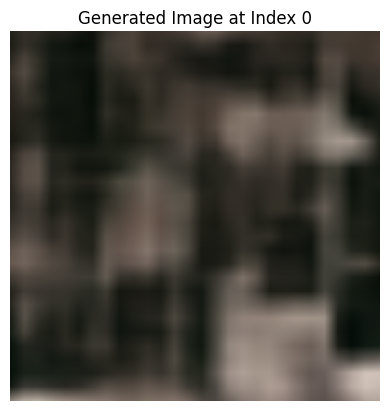

  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:31,  1.04s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:33,  1.07s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:32,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:11<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:23<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:34<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:45<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:46<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:57<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:35,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:08<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:09<00:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:20<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:31<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 26/200, Loss: 835.0061693512991


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:31,  1.04s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:33,  1.07s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:32,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:45<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:33,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:08<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 27/200, Loss: 825.4855332963922


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:32,  1.05s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:33,  1.07s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:32,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:11<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:34<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:01,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:45<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:57<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:35,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:08<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:20<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:31<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 28/200, Loss: 819.1836979898175


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:31,  1.04s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:33,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:32,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:45<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:57<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:08<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:31<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 29/200, Loss: 818.8172165088439


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:31,  1.04s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:33,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:32,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:11<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:34<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:45<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:46<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:57<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:08<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:09<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:20<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:21<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:31<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:32<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 30/200, Loss: 806.1301907314344


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:31,  1.04s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:33,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:32,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:11<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:34<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:45<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:57<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:08<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:31<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 31/200, Loss: 798.6626909234551


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:33,  1.06s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:31,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:29,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:45<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:21,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 32/200, Loss: 787.3459575524491


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:33,  1.06s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:22,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:21,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 33/200, Loss: 784.5991848720594


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:33,  1.07s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:32,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:45<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:57<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:08<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:20<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:31<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:32<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 34/200, Loss: 778.2545454046699


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:33,  1.06s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:33,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:31,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:58,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:45<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:57<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:08<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:20<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:31<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 35/200, Loss: 765.533890284849


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:33,  1.06s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:11<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:05,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:04,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:03,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:22,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 36/200, Loss: 759.9047858420382


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:33,  1.06s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:31,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:45<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:50,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:08<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:22,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 37/200, Loss: 750.3479353658269


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:32,  1.05s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:31,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:05,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:04,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:52,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:22,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 38/200, Loss: 742.9671812593267


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:32,  1.05s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:33,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:34,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:33,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:32,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:31,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:11<01:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:05,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:34<01:04,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 39/200, Loss: 742.64662530449


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:33,  1.06s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:33,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:18,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:17,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:16,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:22,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 40/200, Loss: 737.1286634809516


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:33,  1.06s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:31,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:17,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:05,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:34<01:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:22,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:30<00:07,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 41/200, Loss: 733.4592628050386


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:32,  1.05s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:33,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:45<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 42/200, Loss: 726.0886477352528


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:33,  1.06s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:45<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:51,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:08<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:31<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 43/200, Loss: 721.5251732301176


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:34,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:45<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:57<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:08<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:20<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:31<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 44/200, Loss: 715.15144262421


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:34,  1.07s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:45<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:08<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 45/200, Loss: 710.6449266069391


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:33,  1.06s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:31,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:18,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:16,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:15,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:03,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 46/200, Loss: 713.9534836672665


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:34,  1.07s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:17,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:05,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:04,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:03,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:56,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 47/200, Loss: 703.1003589415818


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:32,  1.05s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:33,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:34<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:02,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:45<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:08<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:20<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:31<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 48/200, Loss: 696.2912350772472


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:34,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:16,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 49/200, Loss: 691.7388250801


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:34,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:16,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:02,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:21,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:30<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 50/200, Loss: 681.6467532040028


Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


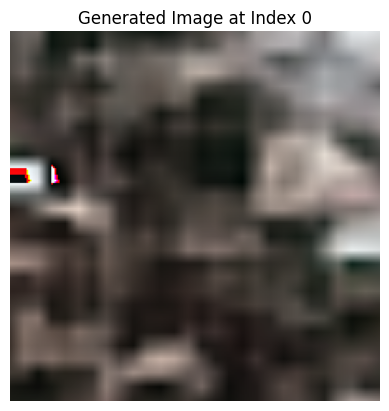

  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:30,  1.03s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:33,  1.07s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:32,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:11<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:16,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:04,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:03,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:45<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:33,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 51/200, Loss: 686.4402630409498


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:33,  1.06s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:29,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:16,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:15,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:45<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 52/200, Loss: 676.358833913053


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:29,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:16,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:15,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:14,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:34<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:32,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 53/200, Loss: 677.3668771808067


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:35,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:29,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:28,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:11<01:27,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:33,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:32,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 54/200, Loss: 671.1666883832953


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:15,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:14,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:44,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:32,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 55/200, Loss: 663.5129346526071


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:34,  1.07s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:27,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:26,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:44,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:43,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 56/200, Loss: 663.4484129487798


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:34,  1.07s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:29,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:27,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:56,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 57/200, Loss: 669.1896478888693


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:34,  1.07s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:27,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:56,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 58/200, Loss: 664.9095952751932


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:35,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:35,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:13,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:56,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:47,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:46,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:44,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:35,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:31<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 59/200, Loss: 656.5463393993592


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:33,  1.06s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:56,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:55,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:44,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:43,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:31,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 60/200, Loss: 653.5193793478976


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:35,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:25,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:09,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:34<01:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:56,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:55,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:45<00:52,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:44,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:43,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:56<00:42,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:07<00:30,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:18<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:29<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:30<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 61/200, Loss: 644.5340209275149


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:33,  1.06s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:24,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:11,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:09,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:08,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:34<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:56,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:55,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:46,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:44,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 62/200, Loss: 638.9364702889089


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:37,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:36,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:09,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:58,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:56,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:55,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:54,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:46,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 63/200, Loss: 631.8288279329793


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:40,  1.14s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:36,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:08,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:07,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:34<01:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:58,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:54,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:11,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 64/200, Loss: 632.559955382615


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:34,  1.07s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:37,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:35,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:21,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:06,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:58,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:53,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:46,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:11,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 65/200, Loss: 645.9543889077862


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:35,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:35,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:33,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:06,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:58,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:45<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:08<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:31<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 66/200, Loss: 626.4832633372104


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:37,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:34<01:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:19<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 67/200, Loss: 621.7504971964976


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:33,  1.06s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:18,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:17,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:34<01:04,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:03,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:21,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 68/200, Loss: 622.7571126530679


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:33,  1.06s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:32,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:32,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:17,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:16,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:15,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:03,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:02,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:21,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 69/200, Loss: 624.5683370868811


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:35,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:35,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:15,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 70/200, Loss: 614.6415676159805


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:35,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:28,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:15,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:56<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:33,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:32,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 71/200, Loss: 622.4888360527125


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:32,  1.06s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:33,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:27,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:14,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:34<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:59,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:56,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:44,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:30<00:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 72/200, Loss: 612.1588007894794


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:34,  1.07s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:27,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:26,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:14,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:13,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:12,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:11,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:34<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:56,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:45<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:46,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:44,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:32,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:07<00:31,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:30<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 73/200, Loss: 611.5757171973753


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:35,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:25,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:24,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:11,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:10,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:08,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:34<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:56,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:45<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:46,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:44,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:43,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 74/200, Loss: 600.4880161928327


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:33,  1.06s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:11<01:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:24,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:11,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:10,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:08,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:58,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:56,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:55,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:54,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:43,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:42,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:11,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:30<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 75/200, Loss: 594.7970803935876


Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


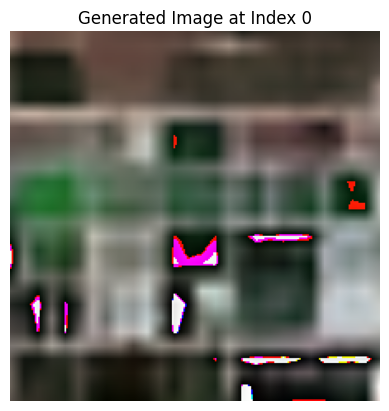

  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:41,  1.15s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:36,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:24,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:23,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:11,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:09,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:08,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:34<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:58,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:58,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:56,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:55,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:44<00:54,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:45<00:52,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:44,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:56<00:42,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:41,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:07<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:18<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:29<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:30<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 76/200, Loss: 596.8557327784849


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:38,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:37,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:35,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:21,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:08,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:07,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:34<01:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:55,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:45<00:52,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:46,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 77/200, Loss: 590.6924541344804


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:33,  1.06s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:34,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:21,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:21,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:19,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:18,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:07,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:34<01:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:52,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:22,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:29<00:08,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:30<00:07,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 78/200, Loss: 588.734140803305


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:35,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:35,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:34,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:33,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:32,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:11<01:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:22,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:21,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:20,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:18,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:22<01:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:06,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:33<01:05,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:34<01:04,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:45<00:52,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:56<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:07<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:22,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:21,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:18<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:11,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:29<00:08,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:30<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 79/200, Loss: 593.7655214459709


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:33,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:32,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:11<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:19,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:18,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:17,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:22<01:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:05,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:34<01:04,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:03,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:02,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:45<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:51,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:56<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:07<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:18<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:30<00:07,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 80/200, Loss: 588.387521808067


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:33,  1.06s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:32,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:31,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:18,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:16,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:34<01:04,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:03,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:02,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:56<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:33,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:07<00:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:30<00:07,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 81/200, Loss: 581.3589474110121


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:34,  1.07s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:29,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:29,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:11<01:27,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:15,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:15,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:13,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:34<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:02,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:01,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:45<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:56<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:33,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:32,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:07<00:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:18<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:30<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 82/200, Loss: 582.1205533488413


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:26,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:14,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:13,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:56,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:44,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:43,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:56<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:33,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:32,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:07<00:31,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:29<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:30<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 83/200, Loss: 579.0121514824


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:33,  1.06s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:27,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:26,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:13,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:12,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:11,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:09,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<00:59,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:56,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:47,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:46,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:43,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:35,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 84/200, Loss: 581.4763780229547


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:41,  1.15s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:37,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:35,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:11<01:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:26,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:25,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:24,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:23,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:22,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:20,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:22<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:09,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:08,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:33<01:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:34<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:58,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:56,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:55,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:44<00:54,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:45<00:53,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:46,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:55<00:43,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:56<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:07<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:30<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 85/200, Loss: 588.9633555894487


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:38,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:37,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:36,  1.13s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:34,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:32,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:11<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:21,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:19,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:22<01:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:08,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:07,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:06,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:33<01:05,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:34<01:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:55,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:44<00:54,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:45<00:53,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:52,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:55<00:42,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:56<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:39,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:05<00:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:06<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:07<00:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:16<00:22,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:17<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:18<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:27<00:11,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:28<00:10,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:29<00:08,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:30<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 86/200, Loss: 580.0051598709621


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:35,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:35,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:35,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:35,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:33,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:21,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:20,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:20,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:19,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:17,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:22<01:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:06,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:33<01:05,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:34<01:04,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:45<00:52,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:51,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:56<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:07<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:22,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:11,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:29<00:08,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:30<00:07,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 87/200, Loss: 582.0720533735297


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:34,  1.07s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:31,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:19,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:18,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:18,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:22<01:16,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:15,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:06,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:33<01:05,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:34<01:04,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:03,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:45<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:51,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:50,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:49,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:55<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:56<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:06<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:07<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:22,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:17<00:21,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:18<00:20,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:29<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:30<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 88/200, Loss: 576.0575276921304


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:33,  1.06s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:30,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:28,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:18,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:17,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:22<01:16,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:15,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:14,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:34<01:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:03,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:02,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:01,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:56,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:44<00:53,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:45<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:55<00:42,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:56<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:33,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:06<00:32,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:07<00:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:17<00:21,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:18<00:20,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:19,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:28<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:29<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:30<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 89/200, Loss: 572.1365654763212


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:34,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:29,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:11<01:27,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:14,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:13,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:34<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:02,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:01,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<01:00,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:56,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:44<00:53,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:45<00:52,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:44,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:55<00:42,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:56<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:06<00:32,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:07<00:31,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:18<00:19,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:29<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:30<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 90/200, Loss: 570.0519604629345


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:35,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:28,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:27,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:27,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:25,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:13,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:12,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:58,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:56,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:55,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:45<00:52,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:46,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:44,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:32,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:07<00:31,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:30,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:18<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:29<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:30<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 91/200, Loss: 564.5754171650061


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:33,  1.06s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:11,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:09,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:34<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<00:59,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:58,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:56,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:55,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:54,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:46,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:44,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:43,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:42,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:41,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:40,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:18<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:11,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:29<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:30<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 92/200, Loss: 560.6870830407304


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:41,  1.16s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:39,  1.14s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:36,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:34,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:11<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:23,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:22,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:21,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:22<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:08,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:07,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:06,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:33<01:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:34<01:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:44<00:54,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:45<00:53,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:56<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:40,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:39,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:07<00:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:17<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:18<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:11,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:28<00:10,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:29<00:08,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:30<00:07,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 93/200, Loss: 580.9230717005355


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:34,  1.07s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:36,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:36,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:35,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:33,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:32,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:11<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:21,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:21,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:19,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:18,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:17,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:22<01:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:07,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:06,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:33<01:05,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:34<01:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:58,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:45<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:07<00:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:22,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:21,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:18<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:29<00:08,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:30<00:07,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 94/200, Loss: 582.626945581329


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:34,  1.07s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:33,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:16,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:34<01:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:03,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:02,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:45<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:56<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:33,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:32,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:07<00:31,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:22,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:17<00:21,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:18<00:20,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:19,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:29<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:30<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 95/200, Loss: 566.838308270058


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:32,  1.05s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:29,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:28,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:27,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:26,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:16,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:14,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:56,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:45<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:44,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:43,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:56<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:32,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:07<00:31,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:30,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:30<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 96/200, Loss: 556.7955936046129


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:32,  1.05s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:25,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:24,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:11,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:09,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<00:59,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:56,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:55,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:54,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:46,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:43,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:07<00:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:29<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 97/200, Loss: 561.3599414611131


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:37,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:37,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:24,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:22,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:21,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:19,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:09,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:08,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:07,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:06,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:33<01:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:34<01:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:56,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:55,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:44<00:54,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:45<00:53,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:56<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:07<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:18<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:11,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:29<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:30<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 98/200, Loss: 553.1436489833875


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:42,  1.17s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:39,  1.15s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:37,  1.13s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:35,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:33,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:11<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:22,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:22,  1.13s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:21,  1.13s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:19,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:21<01:17,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:22<01:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:07,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:32<01:06,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:33<01:06,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:34<01:04,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:43<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:44<00:53,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:45<00:52,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:51,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:54<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:55<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:56<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:38,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:04<00:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:05<00:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:06<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:07<00:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:15<00:23,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:16<00:22,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:17<00:21,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:18<00:19,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:26<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:27<00:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:28<00:09,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:29<00:08,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:30<00:07,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.10s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 99/200, Loss: 564.1742063372322


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:33,  1.06s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:31,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:19,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:18,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:22<01:16,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:15,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:05,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:34<01:04,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:03,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:02,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:45<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:51,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:50,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:49,  1.13s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:48,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:55<00:42,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:56<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:33,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:06<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:07<00:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:22,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:17<00:21,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:18<00:19,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:28<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:29<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:30<00:07,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 100/200, Loss: 560.4325708967916


Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


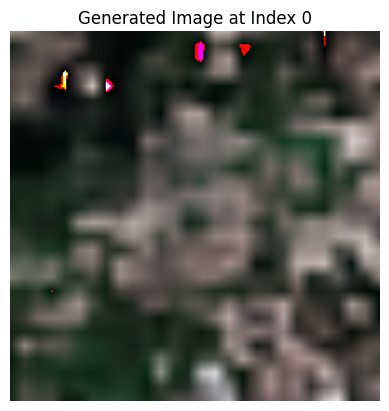

  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:34,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:16,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:34<01:04,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:03,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:02,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:01,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:45<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:50,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:49,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:48,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:44,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:56<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:33,  1.13s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:06<00:32,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:07<00:31,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:22,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:17<00:21,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:18<00:20,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:19,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:28<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:29<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:30<00:07,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 101/200, Loss: 552.2302455259173


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:33,  1.07s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:29,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:28,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:16,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:15,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:14,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:13,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:34<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:01,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:45<00:52,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:44,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:43,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:56<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:33,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:32,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:07<00:31,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:18<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.13s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:29<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:30<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.13s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 102/200, Loss: 548.158537789677


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:35,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:27,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:26,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:13,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:12,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:59,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:56,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:55,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:46,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:44,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:43,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:56<00:42,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:07<00:31,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:30,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:29,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:29<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:30<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 103/200, Loss: 550.6297631424464


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:41,  1.16s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:37,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:35,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:24,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:24,  1.13s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:22,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:21,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:22<01:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:09,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:07,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:33<01:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:34<01:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:58,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:55,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:44<00:54,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:45<00:52,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:46,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:56<00:42,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:41,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:40,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:06<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:07<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:17<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:18<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:29<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:30<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 104/200, Loss: 545.7413858135095


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:38,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:38,  1.13s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:36,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:36,  1.13s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:34,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:32,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:11<01:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:23,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:21,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:20,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:20,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:18,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:21<01:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:22<01:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:07,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:32<01:06,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:33<01:05,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:34<01:04,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:44<00:54,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:45<00:53,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:52,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:51,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:54<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:55<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:56<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:37,  1.13s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:04<00:34,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:05<00:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:06<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:07<00:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:15<00:23,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:16<00:22,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:17<00:21,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:18<00:19,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:27<00:11,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:28<00:09,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:29<00:08,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:30<00:07,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 105/200, Loss: 545.9902417472239


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:33,  1.06s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:34,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:33,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:32,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:31,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:11<01:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:20,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:19,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:19,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:18,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:22<01:16,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:15,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:33<01:05,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:34<01:04,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:03,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:02,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:44<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:45<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:50,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:49,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:55<00:42,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:56<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:05<00:33,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:06<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:07<00:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:16<00:22,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:17<00:21,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:18<00:20,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:28<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:29<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:30<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 106/200, Loss: 547.222198143434


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:37,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:32,  1.13s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:31,  1.13s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:10<01:29,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:11<01:27,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:17,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:22<01:17,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:15,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:14,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:33<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:34<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:03,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:02,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:01,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<01:00,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:56,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:44<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:45<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:44,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:55<00:42,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:56<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:34,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:05<00:33,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:06<00:32,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:07<00:31,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:16<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:17<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:18<00:19,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:27<00:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:28<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:29<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:30<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 107/200, Loss: 546.9135831339976


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:29,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:29,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:11<01:28,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:27,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:25,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:24,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:22<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:15,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:14,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:13,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:12,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:11,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:09,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:32<01:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:33<01:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:34<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:59,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:58,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:56,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:43<00:55,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:44<00:53,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:45<00:52,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:54<00:44,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:55<00:43,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:56<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:05<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:06<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:07<00:30,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:16<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:17<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:18<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:27<00:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:28<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:29<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:30<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 108/200, Loss: 547.4264677240608


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:32,  1.05s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:26,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:25,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:25,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:23,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:21,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:12,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:11,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:10,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:09,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:07,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:33<01:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:34<01:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:59,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:56,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:43<00:56,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:44<00:54,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:45<00:53,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:55<00:43,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:56<00:42,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:41,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:40,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:06<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:07<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:28,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:16<00:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:17<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:18<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:26<00:12,  1.13s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:27<00:11,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:28<00:09,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:29<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:30<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 109/200, Loss: 547.2864503324702


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:42,  1.17s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:39,  1.14s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:38,  1.14s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:35,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:33,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:11<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:24,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:23,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:22,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:21,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:20,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:18,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:21<01:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:22<01:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:10,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:09,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:08,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:32<01:07,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:33<01:05,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:34<01:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:43<00:55,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:44<00:54,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:45<00:53,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:53,  1.13s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:51,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:53<00:44,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:54<00:43,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:55<00:42,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:56<00:41,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:40,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:04<00:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:05<00:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:06<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:07<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:14<00:24,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:15<00:23,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:16<00:22,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:17<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:18<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:26<00:12,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:27<00:11,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:28<00:10,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:29<00:09,  1.13s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:30<00:07,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:36<00:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.10s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 110/200, Loss: 540.3824486893214


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:34,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:35,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:35,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:34,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:33,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:32,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:11<01:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:20,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:18,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:21<01:18,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:22<01:16,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:15,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:06,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:33<01:05,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:34<01:05,  1.13s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:04,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:02,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:43<00:54,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:44<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:45<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:49,  1.13s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:48,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:53<00:45,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:54<00:44,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:55<00:42,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:56<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:38,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:04<00:34,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:05<00:33,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:06<00:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:07<00:30,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:15<00:23,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:16<00:22,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:17<00:21,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:18<00:20,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:26<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:27<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:28<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:29<00:08,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:30<00:07,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.13s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:35<00:03,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:36<00:02,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.10s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 111/200, Loss: 540.0822212133514


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:33,  1.06s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:34,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:32,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:31,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:30,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:30,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:28,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:11<01:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:16,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:15,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:34<01:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:02,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:01,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:55,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:45<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:46,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:44,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:56<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:32,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:07<00:31,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:22,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:18<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:30<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 112/200, Loss: 545.246971901883


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:32,  1.05s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:33,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:33,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:32,  1.08s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:29,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:27,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:26,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:22<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:12,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:10,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:05,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:32<01:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:33<01:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:58,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:57,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:56,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:54,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:43<00:53,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:44<00:52,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:46,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:45,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:44,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:43,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:55<00:42,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:40,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:39,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:34,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:05<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:06<00:30,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:30,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:21,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:16<00:20,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:17<00:19,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:18<00:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:10,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:27<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:28<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:30<00:07,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 113/200, Loss: 542.6153598742538


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:40,  1.14s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:36,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  3%|▎         | 3/89 [00:03<01:34,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  4%|▍         | 4/89 [00:04<01:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  6%|▌         | 5/89 [00:05<01:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  7%|▋         | 6/89 [00:06<01:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  8%|▊         | 7/89 [00:07<01:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  9%|▉         | 8/89 [00:08<01:28,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 10%|█         | 9/89 [00:09<01:27,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 11%|█         | 10/89 [00:10<01:26,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 12%|█▏        | 11/89 [00:12<01:25,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 13%|█▎        | 12/89 [00:13<01:25,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 15%|█▍        | 13/89 [00:14<01:24,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 16%|█▌        | 14/89 [00:15<01:23,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 17%|█▋        | 15/89 [00:16<01:21,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 18%|█▊        | 16/89 [00:17<01:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 19%|█▉        | 17/89 [00:18<01:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 20%|██        | 18/89 [00:19<01:17,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 21%|██▏       | 19/89 [00:20<01:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 22%|██▏       | 20/89 [00:21<01:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 24%|██▎       | 21/89 [00:23<01:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 25%|██▍       | 22/89 [00:24<01:13,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 26%|██▌       | 23/89 [00:25<01:12,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 27%|██▋       | 24/89 [00:26<01:11,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 28%|██▊       | 25/89 [00:27<01:11,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 29%|██▉       | 26/89 [00:28<01:10,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 30%|███       | 27/89 [00:29<01:09,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 31%|███▏      | 28/89 [00:30<01:07,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 33%|███▎      | 29/89 [00:31<01:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 34%|███▎      | 30/89 [00:33<01:04,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 35%|███▍      | 31/89 [00:34<01:03,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 36%|███▌      | 32/89 [00:35<01:02,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 37%|███▋      | 33/89 [00:36<01:01,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 38%|███▊      | 34/89 [00:37<01:00,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 39%|███▉      | 35/89 [00:38<00:59,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 40%|████      | 36/89 [00:39<00:57,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 42%|████▏     | 37/89 [00:40<00:56,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 43%|████▎     | 38/89 [00:41<00:56,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 44%|████▍     | 39/89 [00:42<00:55,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 45%|████▍     | 40/89 [00:44<00:54,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 46%|████▌     | 41/89 [00:45<00:53,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 47%|████▋     | 42/89 [00:46<00:51,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 48%|████▊     | 43/89 [00:47<00:50,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 49%|████▉     | 44/89 [00:48<00:49,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 51%|█████     | 45/89 [00:49<00:48,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 52%|█████▏    | 46/89 [00:50<00:47,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 53%|█████▎    | 47/89 [00:51<00:45,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 54%|█████▍    | 48/89 [00:52<00:44,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 55%|█████▌    | 49/89 [00:53<00:43,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 56%|█████▌    | 50/89 [00:54<00:42,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 57%|█████▋    | 51/89 [00:56<00:41,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 58%|█████▊    | 52/89 [00:57<00:41,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 60%|█████▉    | 53/89 [00:58<00:40,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 61%|██████    | 54/89 [00:59<00:38,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 62%|██████▏   | 55/89 [01:00<00:37,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 63%|██████▎   | 56/89 [01:01<00:36,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 64%|██████▍   | 57/89 [01:02<00:35,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 65%|██████▌   | 58/89 [01:03<00:33,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 66%|██████▋   | 59/89 [01:04<00:32,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 67%|██████▋   | 60/89 [01:06<00:31,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 69%|██████▊   | 61/89 [01:07<00:30,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 70%|██████▉   | 62/89 [01:08<00:29,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 71%|███████   | 63/89 [01:09<00:28,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 72%|███████▏  | 64/89 [01:10<00:27,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 73%|███████▎  | 65/89 [01:11<00:26,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 74%|███████▍  | 66/89 [01:12<00:25,  1.12s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 75%|███████▌  | 67/89 [01:13<00:24,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 76%|███████▋  | 68/89 [01:14<00:23,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 78%|███████▊  | 69/89 [01:15<00:22,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 79%|███████▊  | 70/89 [01:17<00:20,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 80%|███████▉  | 71/89 [01:18<00:19,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 81%|████████  | 72/89 [01:19<00:18,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 82%|████████▏ | 73/89 [01:20<00:17,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 83%|████████▎ | 74/89 [01:21<00:16,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 84%|████████▍ | 75/89 [01:22<00:15,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 85%|████████▌ | 76/89 [01:23<00:14,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 87%|████████▋ | 77/89 [01:24<00:13,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 88%|████████▊ | 78/89 [01:25<00:12,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 89%|████████▉ | 79/89 [01:26<00:11,  1.11s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 90%|████████▉ | 80/89 [01:28<00:09,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 91%|█████████ | 81/89 [01:29<00:08,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 92%|█████████▏| 82/89 [01:30<00:07,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 93%|█████████▎| 83/89 [01:31<00:06,  1.10s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 94%|█████████▍| 84/89 [01:32<00:05,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 96%|█████████▌| 85/89 [01:33<00:04,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 97%|█████████▋| 86/89 [01:34<00:03,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


 98%|█████████▊| 87/89 [01:35<00:02,  1.09s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


100%|██████████| 89/89 [01:37<00:00,  1.09s/it]


Swin Encoder Feature Shapes: [torch.Size([2, 56, 56, 128]), torch.Size([2, 28, 28, 256]), torch.Size([2, 14, 14, 512]), torch.Size([2, 7, 7, 1024])]
Epoch 114/200, Loss: 541.40402495995


  0%|          | 0/89 [00:00<?, ?it/s]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  1%|          | 1/89 [00:01<01:43,  1.18s/it]

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


  2%|▏         | 2/89 [00:02<01:40,  1.15s/it]

In [ ]:
# Set up the dataset and dataloader
inputs = "/content/drive/MyDrive/agri/SAR"
targets = "/content/drive/MyDrive/agri/Optical"

# Use the custom dataset and DataLoader for batch loading
dataset = PairedImageDataset(inputs, targets)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Initialize model, loss, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SwinHRNetModel().to(device)
criterion = nn.MSELoss()
perceptual_loss = lpips.LPIPS(net='vgg').to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
epochs = 200
epoch_list = []
loss_list = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in tqdm(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, targets)
        percep_loss = perceptual_loss(outputs, targets).mean()
        total_loss = loss + 0.1 * percep_loss

        epoch_loss += total_loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

    # Append the epoch number and loss to the lists for tracking
    epoch_list.append(epoch + 1)
    loss_list.append(epoch_loss / len(dataloader))

    # Print the average loss for this epoch
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(dataloader)}")

    # Visualization after each epoch (visualize only the first image in the batch)
    if (epoch + 1) % 25 == 0:
        visualize_single_output(model, dataloader, index=0)  # Change index to visualize different images

print("Training completed.")

In [1]:
model1 = SwinHRNetModel().to(device)
model1.load_state_dict(torch.load('/content/drive/MyDrive/Data/model.pt'))
model1.eval()
print(model1)

NameError: name 'model' is not defined

In [ ]:
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt

def predict_single_image(model, image_path, device):
    # Open and process the grayscale input image (256x256)
    image = Image.open(image_path).convert('L')  # Open grayscale image
    image = image.resize((224, 224))  # Resize to match the model input size
    image = image.convert('RGB')  # Convert grayscale to RGB by duplicating channels

    # Convert image to numpy and then to torch tensor (without normalization)
    image_np = np.array(image).astype(np.float32)  # Convert to numpy
    image_tensor = torch.tensor(image_np).permute(2, 0, 1).unsqueeze(0).to(device)  # Add batch dimension and permute

    # Run the model in evaluation mode
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)  # Forward pass
        output_image = output.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # Remove batch and convert to numpy

    # Convert the output to an image format
    output_image = np.clip(output_image, 0, 255).astype(np.uint8)  # Clip values to 0-255 and convert to uint8

    # Display the result
    plt.imshow(output_image)
    plt.axis('off')
    plt.title('Predicted Color Image')
    plt.show()
# Use the model directly without loading it from a file
predict_single_image(model1,'/content/ROIs1868_summer_s1_59_p2.png', device)